## Model and Error Analysis

`Structure`:

1. load data 
-  exclude instances with imputed target value
- "recombine" with time steps for temporal residual analysis

2. metrics based analysis (MAE, RMSE, MAPE, MDAPE, R2)
- plot distribution of true und predicted value (arranged by true value)

3. residual analysis 

- scatter residual plot against y_true (per model and site)
- meterological feature wise residual plot (per model and site)
- temporal residual plot (per model)

4. feature importance
-  shapely value RF 
- sensitivity feature importance GNN


In [2]:
# required feature names: 'y_pred', 'y_true', 'time_step', 'id' (for spatial analysis)
from utilities.error_analysis import spatial_error_analysis
import pandas as pd

results_gnn = pd.read_csv('datasets/results_gnn.csv')
results_rf = pd.read_csv('datasets/results_rf.csv')

error_analysis = spatial_error_analysis(df_models = [results_gnn, results_rf], 
               names_models = ['gnn', 'rf'], # same length as df_models required!
               #spatial= True, # requires attribute 'id' for spatial differentiation
               )


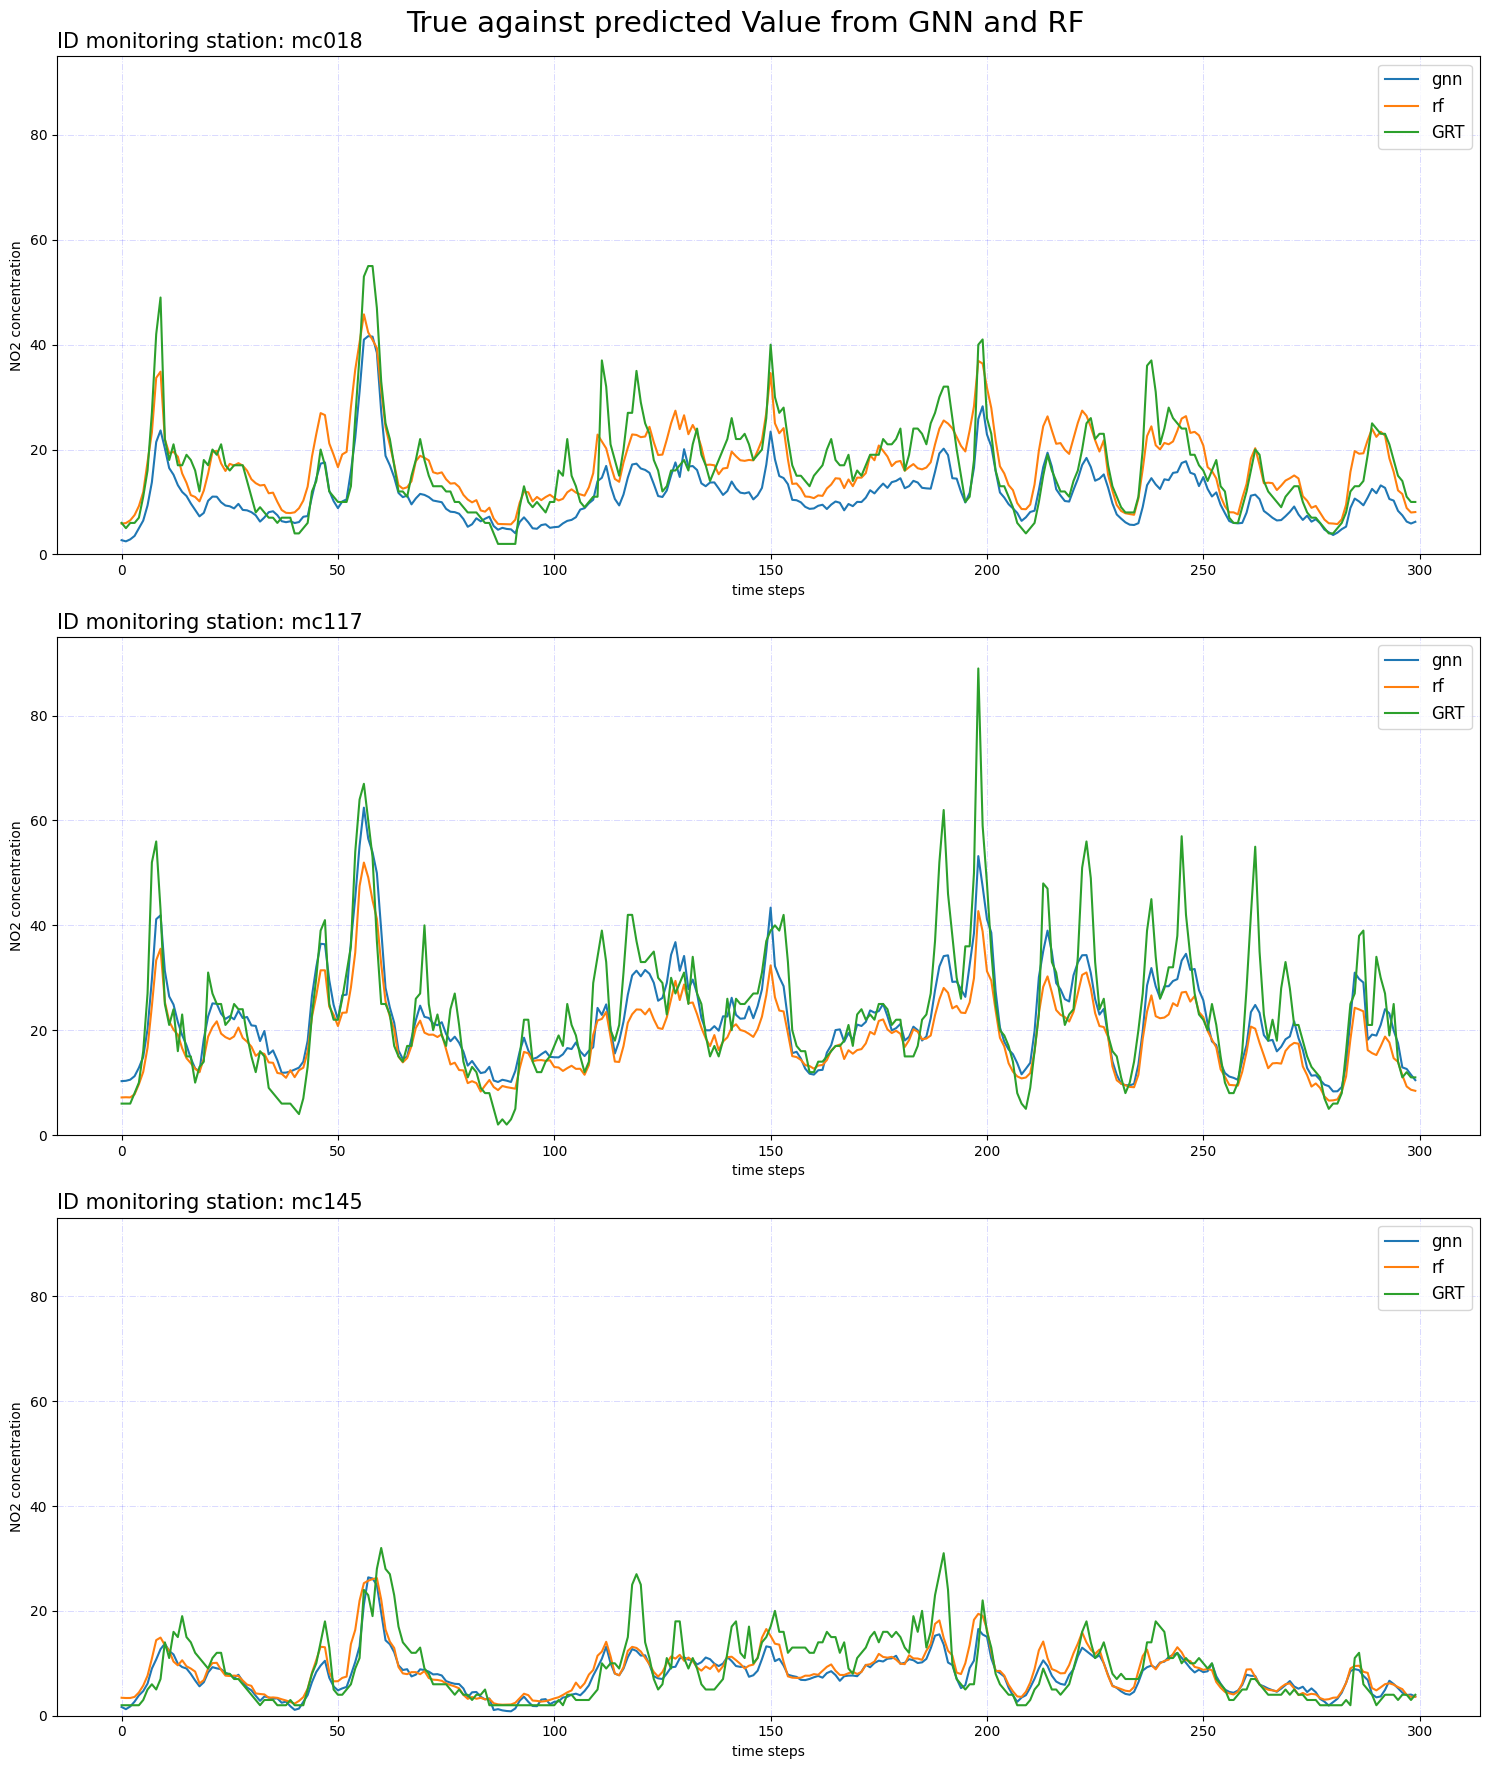

In [3]:
# plot prediction over time
error_analysis.plot_predict_over_time(title= 'True against predicted Value from GNN and RF', 
                                        y_label= 'NO2 concentration', 
                                        n_time_steps = 300, 
                                        save= True,
                                        path= 'figures/true_predict_over_time.png')

In [4]:
# return evaluation/ performance metrics
error_analysis.get_metrics(save= True, path = 'datasets/performance_metrics.csv')

MAE   RMSE   MAPE  MDAPE     R2
gnn_mc018  5.528  7.582  0.367   0.36  0.548
gnn_mc117  5.924  7.772  0.445  0.282  0.654
gnn_mc145  2.392  3.486  0.446  0.339  0.637
gnn_mean   4.615  6.280  0.419  0.327  0.613
rf_mc018   4.215  5.651  0.421  0.256  0.749
rf_mc117    5.85  8.144  0.366  0.276   0.62
rf_mc145    3.13   4.28  0.708  0.437  0.452
rf_mean    4.398  6.025  0.498  0.323  0.607

### residual analysis (Thesis p. 28-30)
Findings:

1. under estimation of peak values and higher variance (funnel shape)
2. higher overestimation (negative residuals) for low value in RF model
3. no significant differences between the models


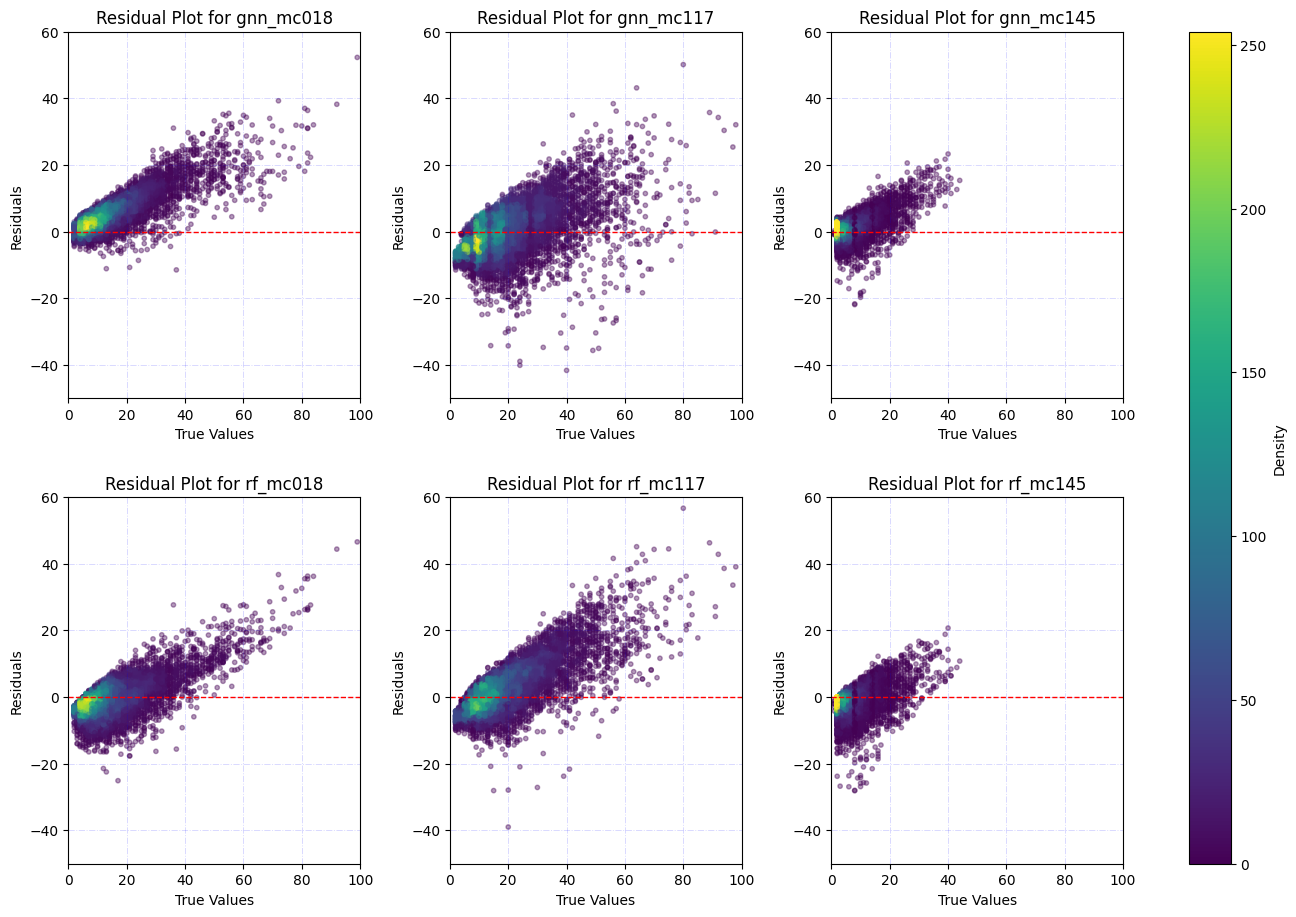

In [8]:
error_analysis.plot_residual_plot(save = True,
                                   path = 'figures/residual_distribution_all_models.png')

In [2]:
# load predicted data by model and filter by measuring site
import pandas as pd

results_gnn = pd.read_csv('datasets/results_gnn.csv')
gnn_mc117 = results_gnn[results_gnn['id'] == 'mc117']
gnn_mc018 = results_gnn[results_gnn['id'] == 'mc018']
gnn_mc145 = results_gnn[results_gnn['id'] == 'mc145']

results_rf = pd.read_csv('datasets/results_rf.csv')
rf_mc117 = results_rf[results_rf['id'] == 'mc117']
rf_mc018 = results_rf[results_rf['id'] == 'mc018']
rf_mc145 = results_rf[results_rf['id'] == 'mc145']

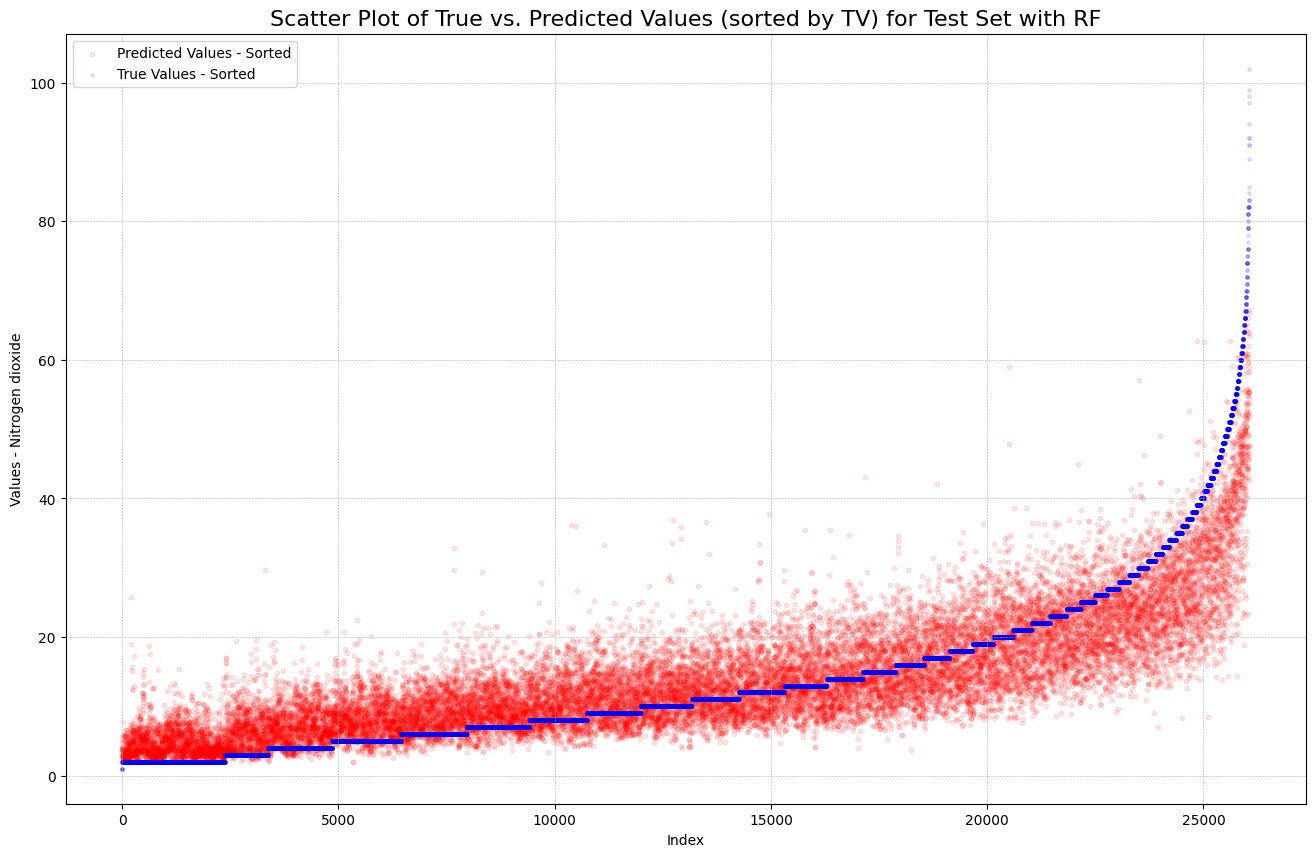

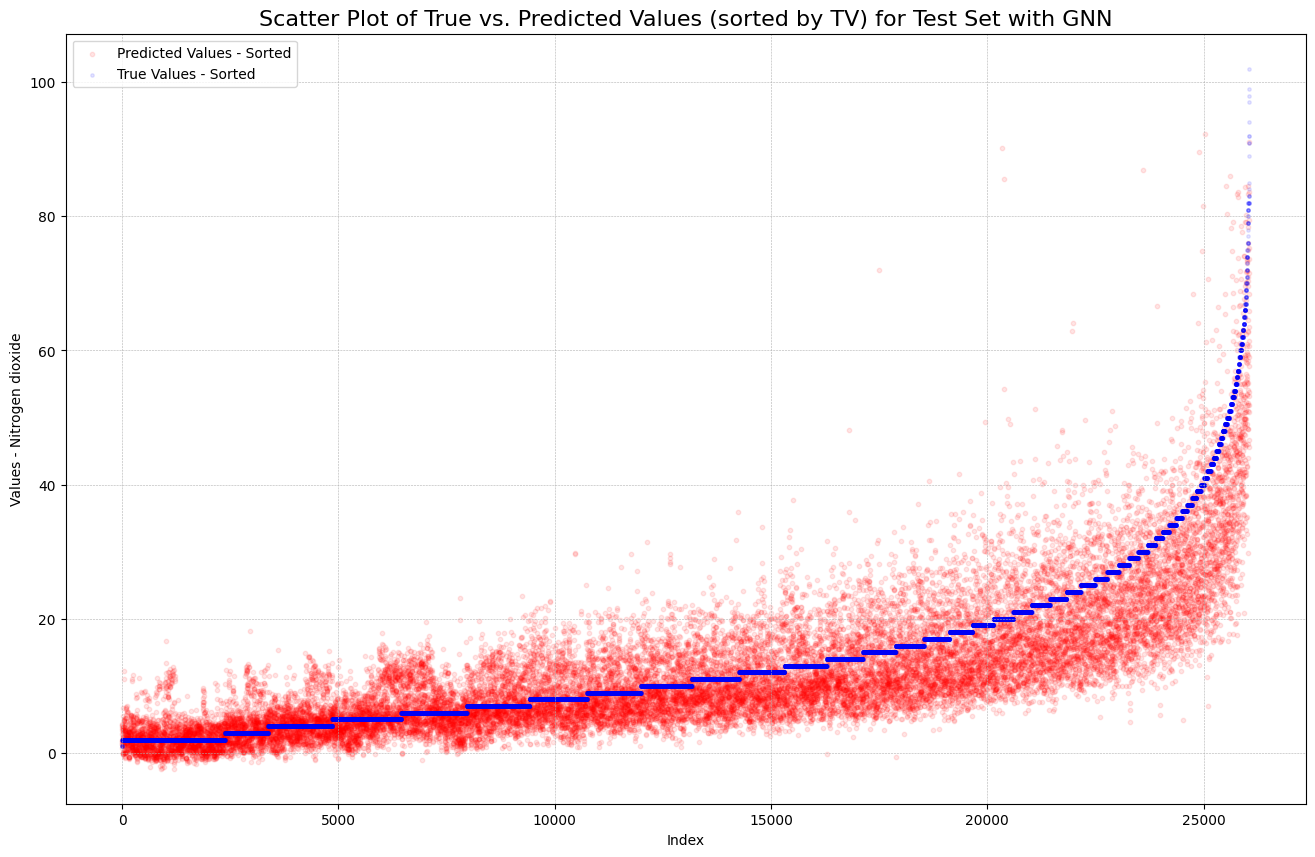

In [9]:
# scatter plot of True vs. Predicted Values (Sorted by True Values)
import matplotlib.pyplot as plt

# Scatter plot
def scatter_plot(dataframe,model_name = None, name = 'all', plot = True):
    dataframe = dataframe.sort_values('y_true') # sort for plotting

    if plot == True:
        plt.figure(figsize=(16, 10))      
        plt.scatter(range(len(dataframe)), dataframe['y_pred'], color='red', alpha=0.1, s= 10, label='Predicted Values - Sorted')
        plt.scatter(range(len(dataframe)), dataframe['y_true'], color= 'blue', alpha=0.1, s = 6, label='True Values - Sorted')
        plt.title(f'Scatter Plot of True vs. Predicted Values (sorted by TV) for {name} with {model_name}', size= 16)
        plt.xlabel('Index (after sorting by True Values)')
        plt.xlabel('Index')
        plt.ylabel('Values - Nitrogen dioxide')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.4)
        plt.savefig(f"figures/scatter_plot_{model_name}_{name.replace(' ','_')}.png", dpi = 200)
        plt.show()

    return 


scatter_plot(results_rf.sort_index(), name= 'Test Set', model_name= 'RF') # plot for RF

scatter_plot(results_gnn.sort_index(), name= 'Test Set', model_name= 'GNN') # plot for GNN

### feature wise residual analysis (Thesis p. 30)

Interpretation:
1. deviation in distribution wind_direction: uncaptured variation between station (maybe spatial positioning (in south west) or local air flow)
2. funnel shape find_speed: low wind = lower prediction abilities (uncaptured NO2 accumulation over time?)

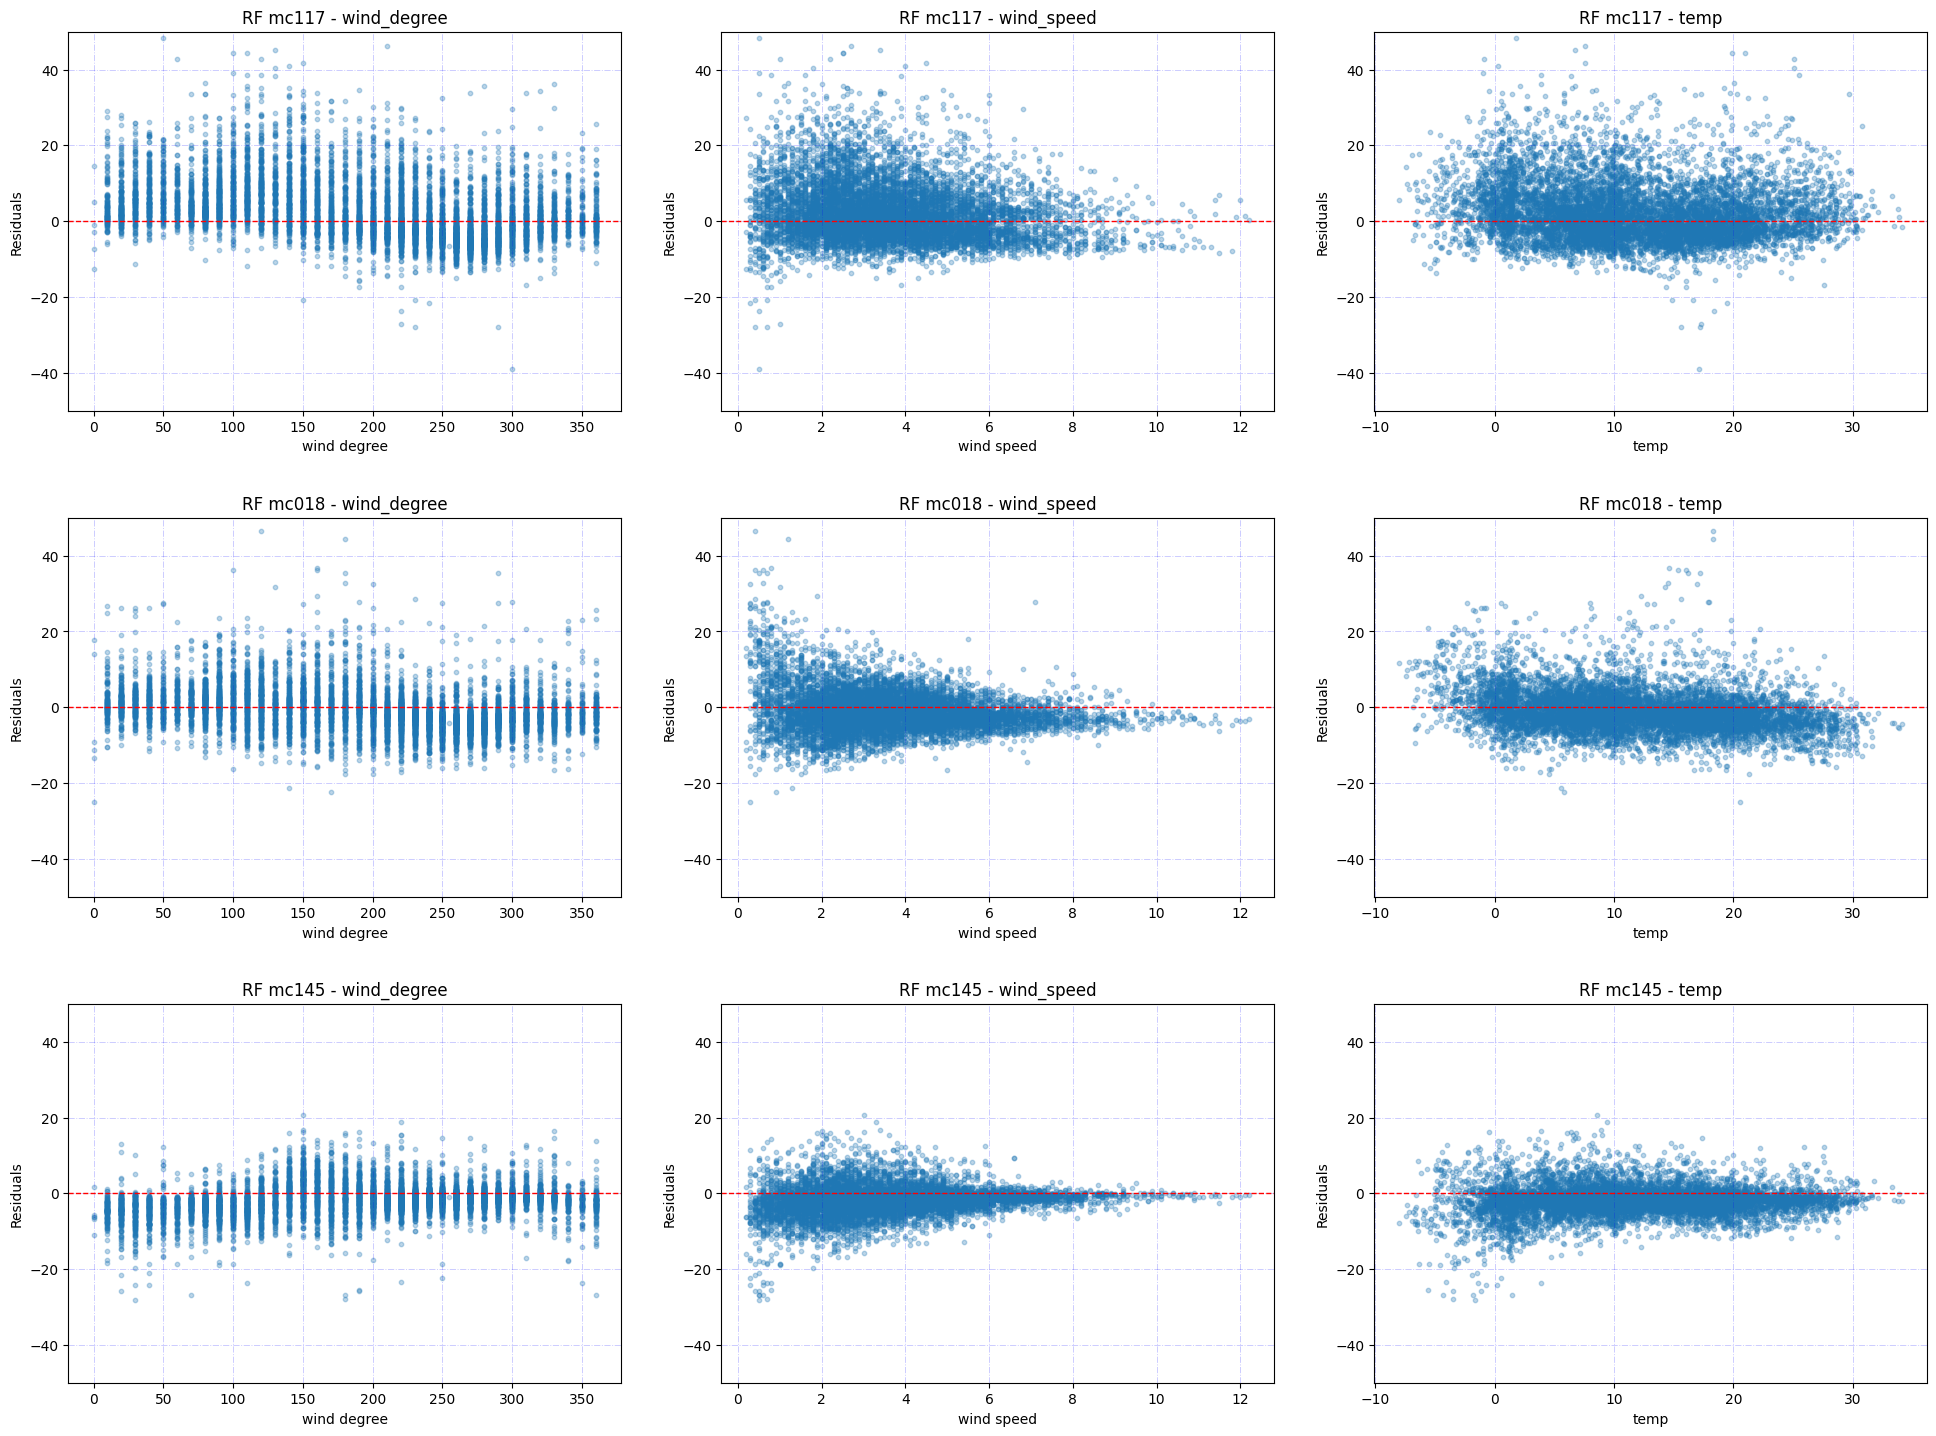

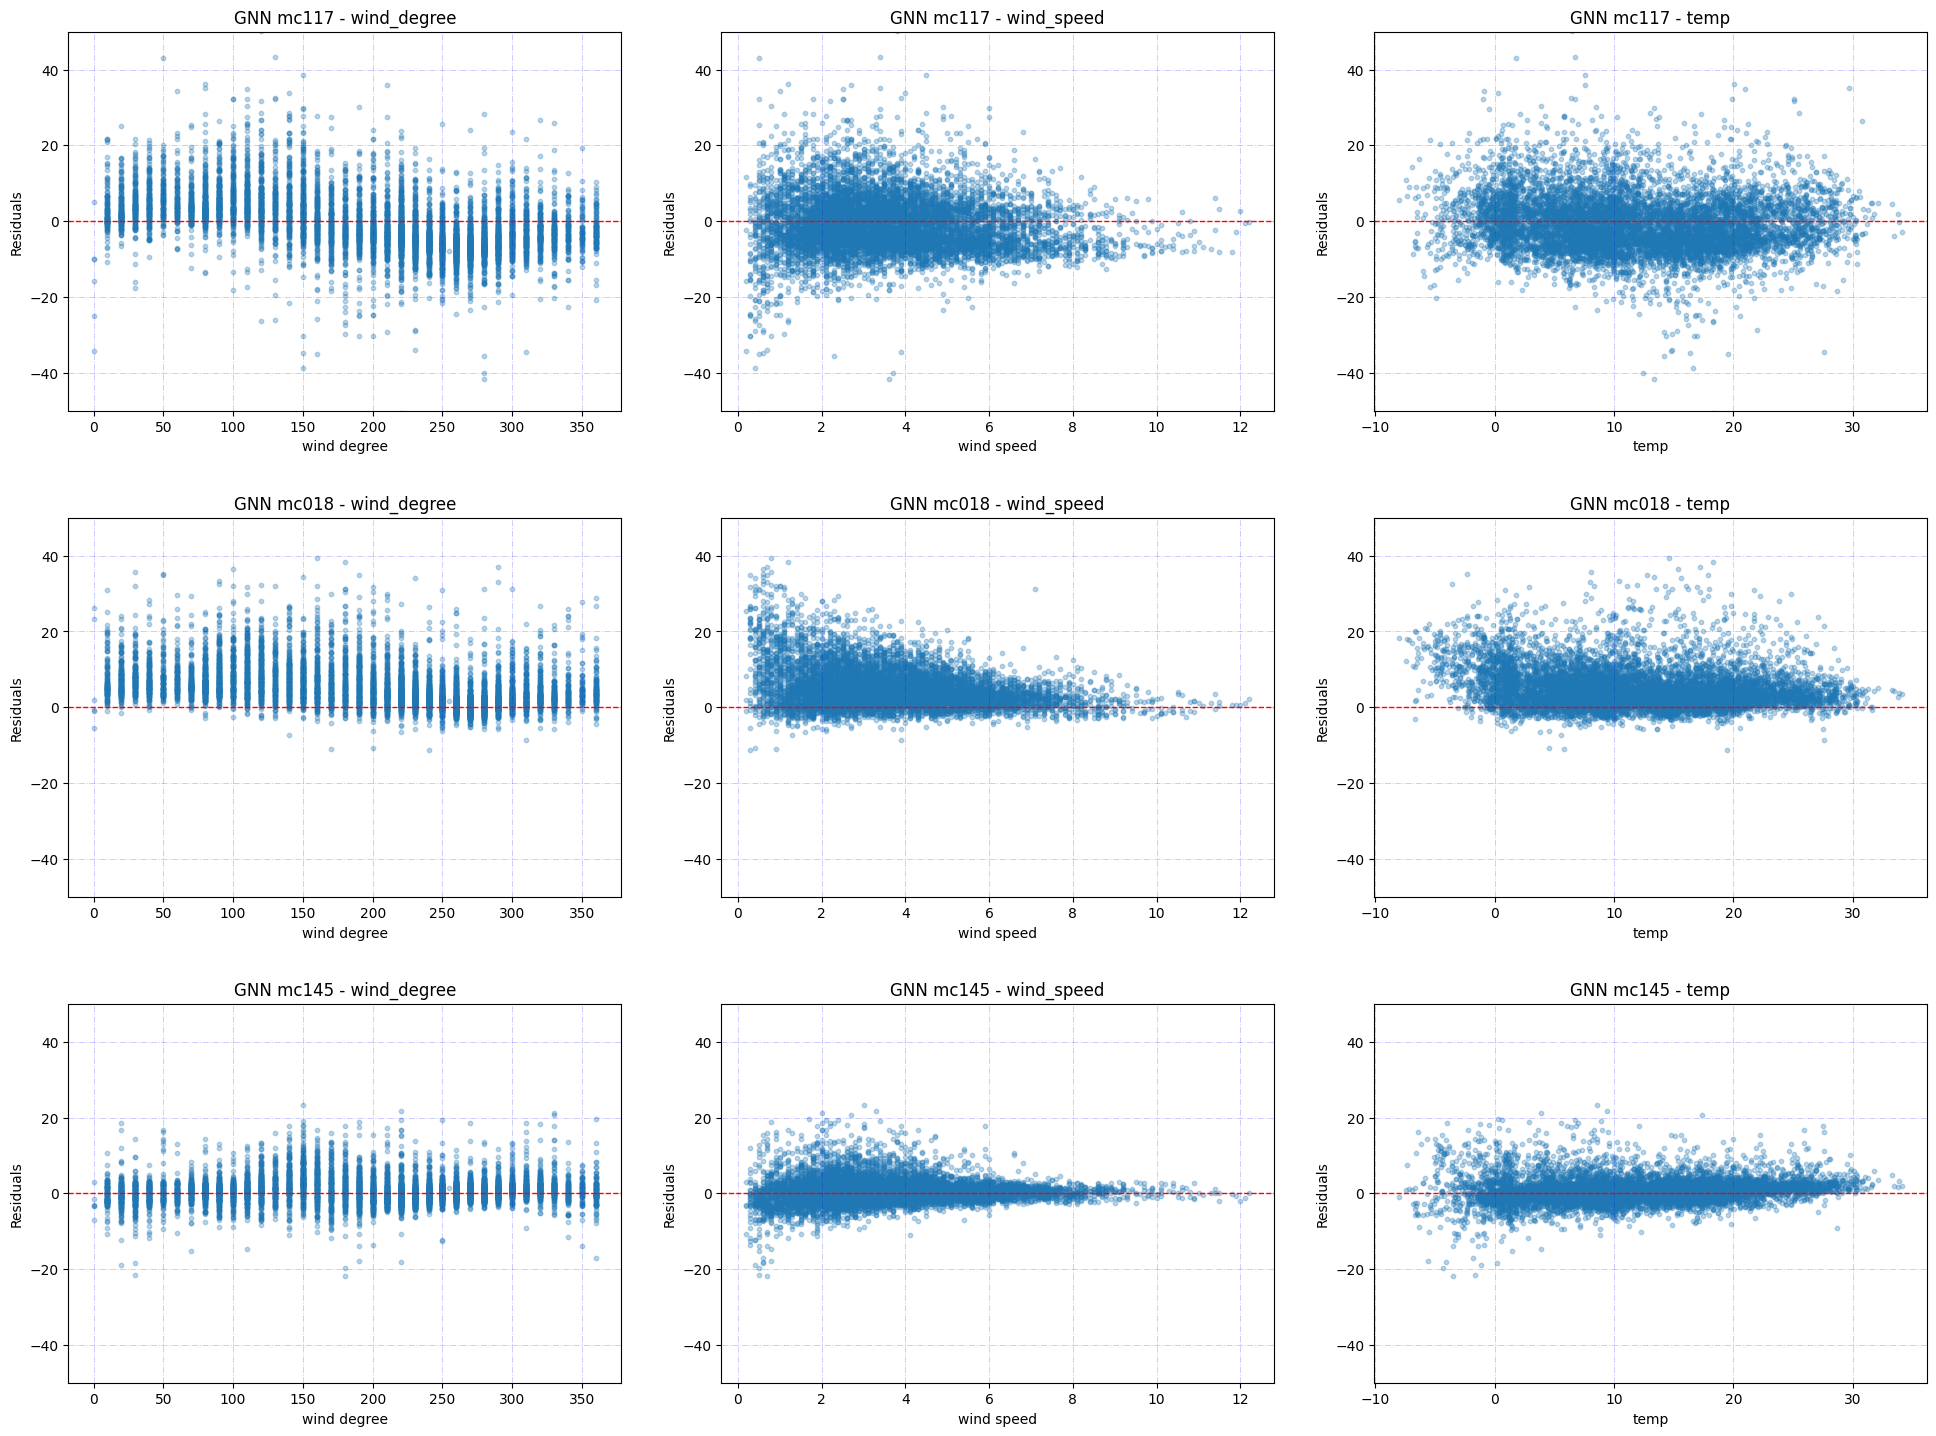

In [11]:
import matplotlib.pyplot as plt


def feature_wise_residual(models, features, name):
    # Create a figure with subplots arranged in a grid
    fig, axs = plt.subplots(len(models), len(features), figsize=(20, 15))  # Adjust size as necessary
    fig.tight_layout(pad=5.0)  # Add space between plots

    # Loop over the models and features to create each subplot
    for model_idx, (model_name, model_data) in enumerate(models.items()):
        for feature_idx, feature in enumerate(features):
            ax = axs[model_idx][feature_idx]  # Select the appropriate subplot
            ax.scatter(model_data[feature], model_data['y_true'] - model_data['y_pred'], alpha=0.3, s=10)
            ax.set_title(f'{model_name} - {feature}')
            ax.set_xlabel(f"{feature.replace('_', ' ')}")
            ax.set_ylabel('Residuals')
            ax.set_ylim(-50,50)
            ax.grid(color='blue', linestyle='-.', alpha=0.2, linewidth=0.7)
            ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

    
    fig.tight_layout(pad=3.0)
    plt.savefig(f'figures/residual_distribution_{name}.png', dpi=160)
    return plt.show()

feature_wise_residual(models = {'RF mc117': rf_mc117, 'RF mc018': rf_mc018, 'RF mc145': rf_mc145},
                      features = ['wind_degree', 'wind_speed', 'temp'],
                      name = 'meterological_feature_RF')

feature_wise_residual(models = {'GNN mc117': gnn_mc117, 'GNN mc018': gnn_mc018, 'GNN mc145': gnn_mc145},
                      features = ['wind_degree', 'wind_speed', 'temp'],
                      name = 'meterological_feature_GNN')

### temporal dependency (Thesis p. 31)

Interpretation:
1. less accuracy in winter month aligns with previous findings and general distribution of target value

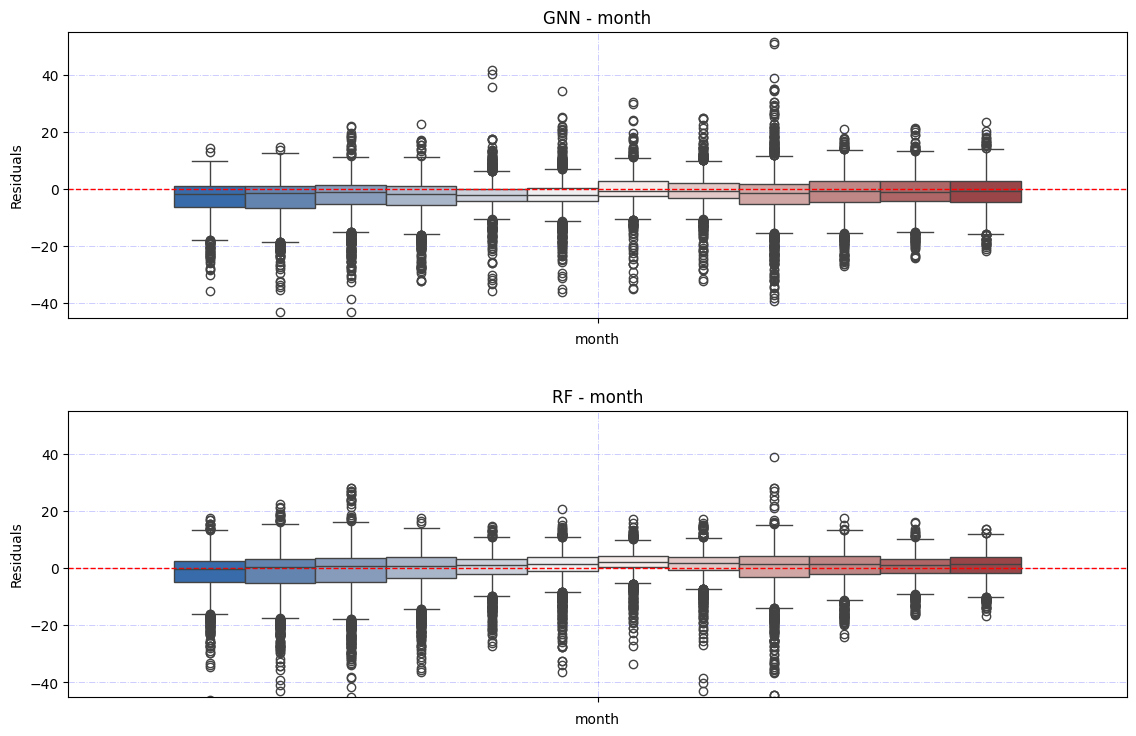

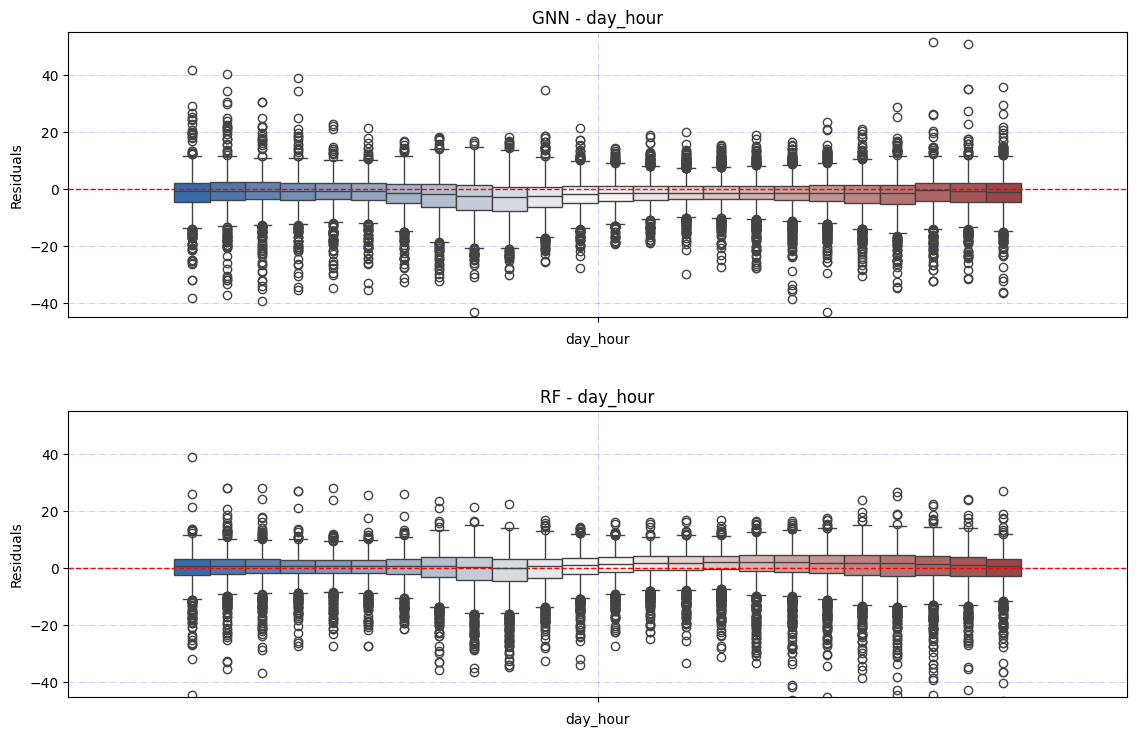

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def temporal_residual(models, temporal_feature):
    
    fig, axs = plt.subplots(len(models), 1, figsize=(12, 8))  
    fig.tight_layout(pad=5.0) 

    # Loop over the models to create each subplot
    for model_idx, (model_name, model_data) in enumerate(models.items()):
        ax = axs[model_idx]  # Select the appropriate subplot
        sns.boxplot(hue=temporal_feature, y=model_data['y_pred']- model_data['y_true'], data=model_data, ax=ax, palette="vlag", legend= False) 
        ax.set_title(f'{model_name} - {temporal_feature}')
        ax.set_xlabel(f'{temporal_feature}')
        ax.set_ylabel('Residuals')
        ax.set_ylim(-45,55) 
        ax.grid(color='blue', linestyle='-.', alpha=0.2, linewidth=0.7)
        ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

    
    fig.tight_layout(pad=3.0)  
    plt.savefig(f'figures/residual_boxplot_{temporal_feature}.png', dpi=200)
    return plt.show()

# add temporal indexing
results_rf['day_hour'] = results_rf['time_step'].apply(lambda x:int(str(x)[-2:])+1)
results_rf['month'] = results_rf['time_step'].apply(lambda x:int(str(x)[4:6]))

results_gnn['day_hour'] = results_gnn['time_step'].apply(lambda x:int(str(x)[-2:])+1)
results_gnn['month'] = results_gnn['time_step'].apply(lambda x:int(str(x)[4:6]))


temporal_residual(models= {'GNN': results_gnn, 'RF': results_rf}, 
                  temporal_feature = 'month')

temporal_residual(models= {'GNN': results_gnn, 'RF': results_rf}, 
                  temporal_feature = 'day_hour')


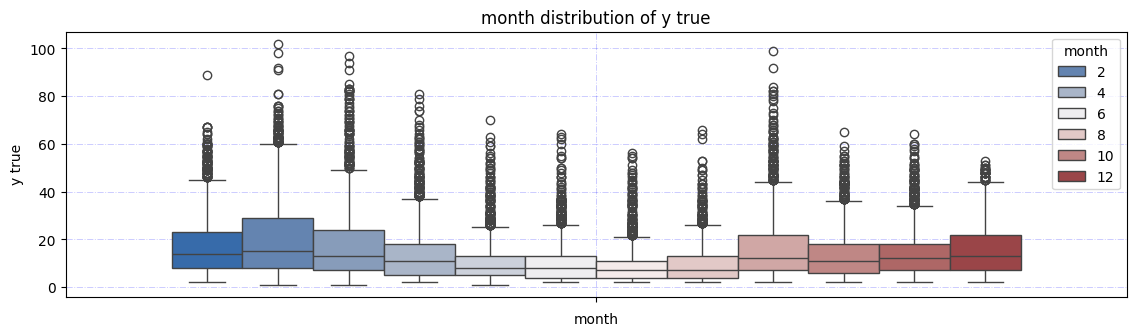

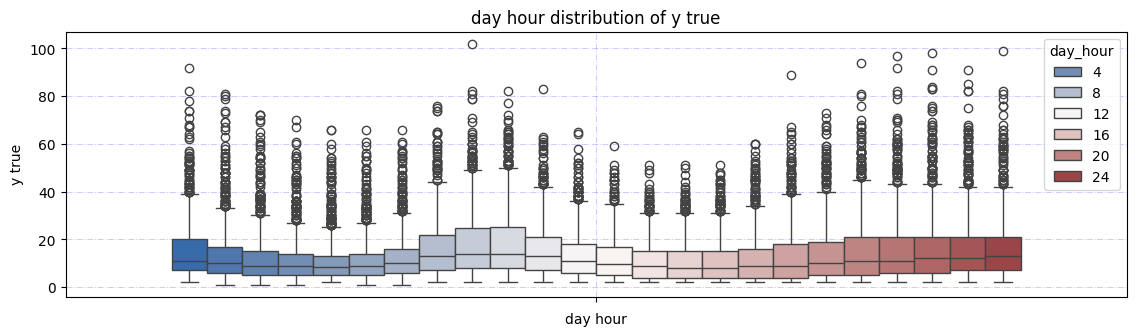

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def temporal_feature_distribution(temporal_feature, dataset, target_feature):
    fig, ax = plt.subplots(figsize=(12, 4)) 
    fig.tight_layout(pad=5.0)            
    
    sns.boxplot(hue=temporal_feature, y='y_true', data=dataset, ax=ax, palette="vlag")
    ax.set_title(f"{temporal_feature.replace('_',' ')} distribution of {target_feature.replace('_',' ')}")
    ax.set_xlabel(f"{temporal_feature.replace('_',' ')}")
    ax.set_ylabel(f"{target_feature.replace('_',' ')}")
    ax.grid(color='blue', linestyle='-.', alpha=0.2, linewidth=0.7)
    fig.tight_layout(pad=3.0)
    #plt.savefig(f'output/performance/png/{target_feature}_boxplot_{temporal_feature}.png', dpi=200)
    return plt.show()

temporal_feature_distribution(temporal_feature = 'month',
                              dataset = results_gnn, 
                              target_feature= 'y_true')

temporal_feature_distribution(temporal_feature = 'day_hour',
                              dataset = results_rf, 
                              target_feature= 'y_true')

### feature importance through shapely value (Thesis p. 33)

In [26]:
# initialize and fit RF Model
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# load train data
train_df = pd.read_csv('data/train_df.csv')

features = ['prec_mm', 'temp', 'wind_degree', 'wind_speed',
       'free_wind', 'prop_intercept_200', 'GVI_25', 'tvi_200', 'prop_main_', 
       'nearest_in', 'pop_500', 'lai_factor', 'weighted_mean_pollution']


parameter = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}

       
X_train = train_df[features]
y_train = train_df['NO2']

model = RandomForestRegressor(**parameter, n_jobs=-1) # initiate model with defined parameter
model.fit(X_train, y_train) 


RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_jobs=-1)

In [11]:
# create and save shapely values (!DONT RUN AGAIN! - takes some time)
import shap
import pandas as pd
import pickle

test_data = pd.read_csv('data/datasets/test_df.csv') 
explainer = shap.Explainer(model) # define type of SHAP
#shap_values = explainer(test_data[features]) # calculate conditional contribution 

#with open('datasets/shap_values_rf.pkl', 'wb') as f: 
#    pickle.dump(shap_values, f)

In [28]:
import shap
print(shap.__version__)

0.46.0


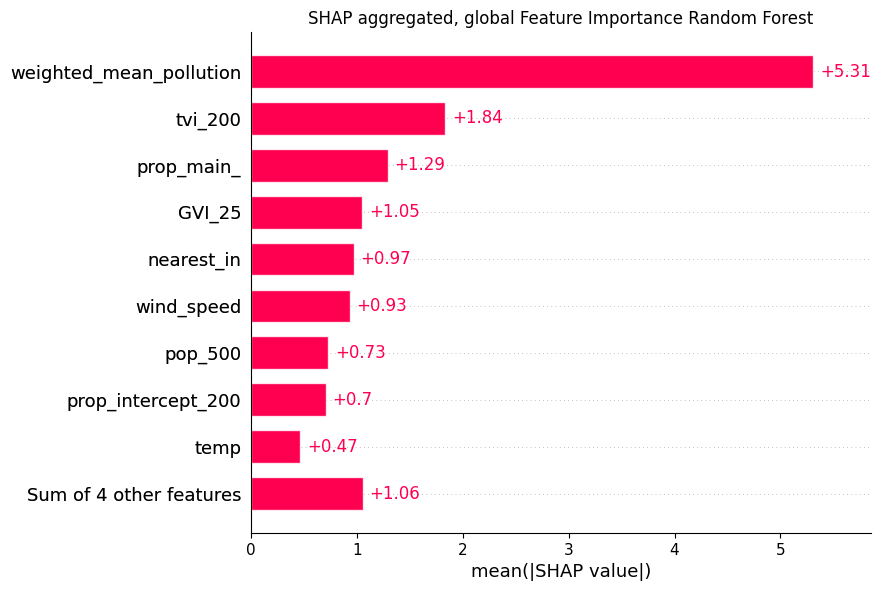

In [29]:
## global feature importance  (Thesis p. 34)
import shap
import matplotlib.pyplot as plt
import pickle


with open('datasets/shap_values_rf.pkl', 'rb') as f:
    shap_values = pickle.load(f)

# Create a SHAP bar plot
shap.plots.bar(shap_values, show= False)
plt.title('SHAP aggregated, global Feature Importance Random Forest')
plt.savefig('figures/shap_global_importance_RF.png', dpi = 180)
plt.show()

To what extent can Shapley values, as local, model agnostic interpretation, be utilized to analyze variations in the mitigation of NO2 concentrations relative to seasonal changes in the Leaf Area Index? p. 39

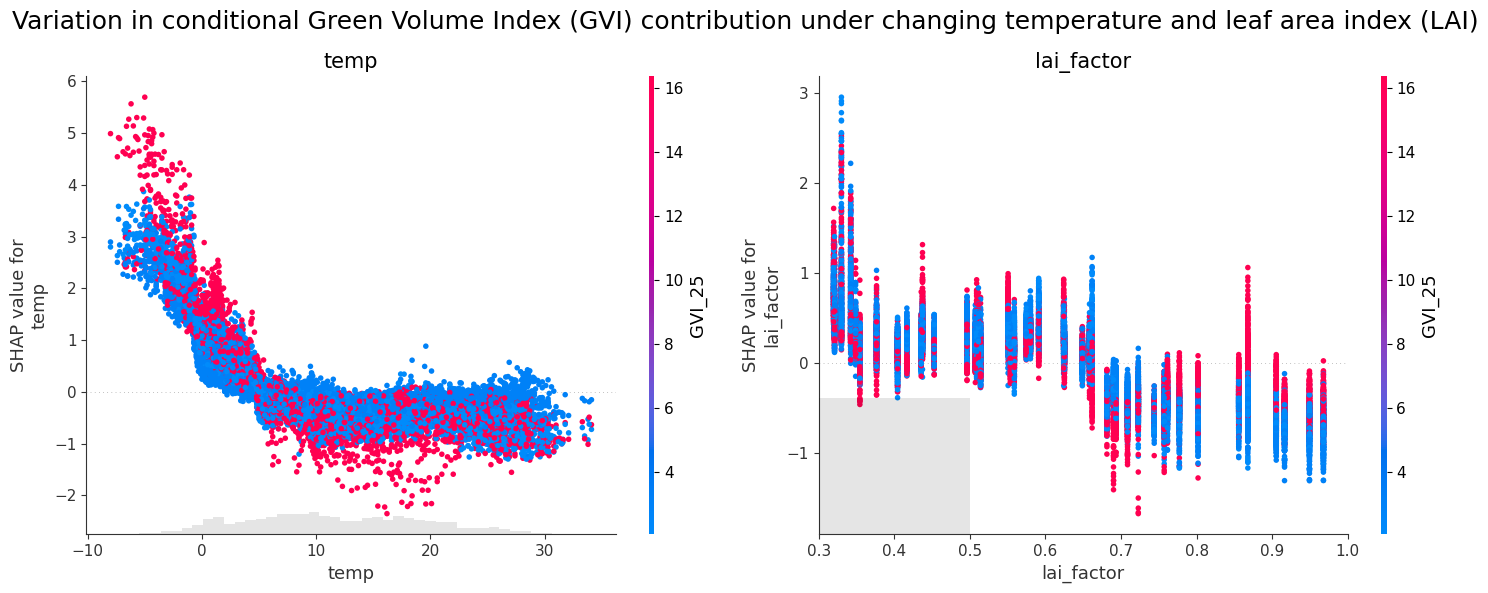

In [31]:
# variation in feature contribution under changing temp and LAI (Thesis p. 36)
import shap
import matplotlib.pyplot as plt


# Features to plot
features = ['temp', 'lai_factor']

# Setup a figure and axes
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Adjust the figsize appropriately
axs = axs.flatten()  # Flatten the array to facilitate easier indexing

# Plotting SHAP scatter plots on each subplot
for i, feature in enumerate(features):
    shap.plots.scatter(shap_values[:,feature], ax = axs[i],show = False,color= shap_values[:, 'GVI_25'])
    axs[i].set_title(feature, size = 15)
    if i%2!=0:
        axs[i].set_xlim(0.3,1)

plt.suptitle('Variation in conditional Green Volume Index (GVI) contribution under changing temperature and leaf area index (LAI)', size =18)
plt.savefig('figures/pdp_temp_lai_gvi_RF.png', dpi = 180)
plt.tight_layout()
plt.show()